In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd

In [4]:
from src.aggregation import (
    aggregate_panel,
    check_panel_balance
)

from src.config import (
    DATA_DIR,
    RESULTS_DIR,
    FIGURES_DIR
)

from src.plotting import (
    set_plot_style
)

set_plot_style()

In [14]:
df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'], low_memory=False)

In [15]:
from src.models_utils import aggregate_time_series

In [16]:
df_m = aggregate_time_series(
    df,
    date_col="EventDate",
    target_cols=["Hospitalized", "Amputation"],
    freq="MS",
    agg="sum",   # counts per month
)

# Focus on the hospitalized global series for now
monthly_hosp = df_m["Hospitalized"]


In [17]:
monthly_hosp.head()

EventDate
2015-01-01    673
2015-02-01    623
2015-03-01    664
2015-04-01    612
2015-05-01    611
Freq: MS, Name: Hospitalized, dtype: int64

In [6]:
from src.features import (
    series_to_national_panel,
    build_panel_features
)

In [35]:
panel_nat = series_to_national_panel(monthly_hosp)

X_nat, y_nat, meta_nat = build_panel_features(
    panel_df=panel_nat,
    target="Hospitalized",
    group_col="State",
    date_col="Date",
    freq="MS",
    state_encoding="none",   # no need for dummy encoding with one group
)


In [19]:
from src.splitting import temporal_panel_split

In [36]:
splits = temporal_panel_split(
    X=X_nat,
    y=y_nat,
    meta=meta_nat,
    date_col='Date',
    train_end='2023-12-01',
    test_start='2024-01-01',
    test_size=12
)

In [37]:
print("Train last date:", splits["train"]["meta"]["Date"].max())
print("Test first date:", splits["test"]["meta"]["Date"].min())
print("Test last date:", splits["test"]["meta"]["Date"].max())

Train last date: 2023-12-01 00:00:00
Test first date: 2024-01-01 00:00:00
Test last date: 2024-12-01 00:00:00


In [38]:
from src.models import get_model_configs, instantiate_models

X_train = splits["train"]["X"]
y_train = splits["train"]["y"]

model_configs = get_model_configs(
    n_samples=len(X_train),
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)

models = instantiate_models(model_configs)

list(models.keys())
# ['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']


['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']

In [39]:
from src.training import train_and_predict_global_models


# 2. Train + predict
results = train_and_predict_global_models(
    models=models,
    splits=splits,
)

# Example: inspect one model's test predictions
ridge_test = results["Ridge"]["test"]
ridge_test["meta"].head()
ridge_test["y_true"].head()
ridge_test["y_pred"].head()


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.732e+04, tolerance: 7.440e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.645e+02, tolerance: 7.440e+01
  model = cd_fast.enet_coordinate_descent(


0    564.629277
1    553.388014
2    572.681518
3    533.401972
4    555.933146
Name: Ridge_pred_test, dtype: float64

In [40]:
from src.evaluation import compute_panel_metrics

metrics = compute_panel_metrics(
    results=results,
    group_col="State",
    metric_names=("rmse", "mae"),
)

global_train = metrics["global"]["train"]
global_test  = metrics["global"]["test"]

In [41]:
print("Global test metrics:")
display(global_test)

Global test metrics:


,rmse,mae
model,,
CatBoost,36.648205,30.954103
ElasticNet,32.755232,24.199853
Lasso,33.184816,24.005831
LightGBM,30.851306,24.623575
PLS,33.050155,24.777155
Ridge,33.427212,25.423695
XGBoost,40.850285,37.238063


In [42]:
from src.evaluation import compute_feature_importances
feature_importances_national_m = compute_feature_importances(
    models=models,
    X=X_nat,
    normalize=True,
)

feature_importances_national_m.head()

,Ridge,Lasso,ElasticNet,PLS,XGBoost,LightGBM,CatBoost
year,0.040532,0.012851,0.026207,0.031479,0.238123,0.136638,0.150158
month,0.119151,0.045880,0.092990,0.122197,0.043190,0.151149,0.102361
quarter,0.015737,0.015104,0.026478,0.036382,0.000000,0.000000,0.030367
month_sin,0.083345,0.025183,0.052605,0.061404,0.045238,0.060459,0.070211
month_cos,0.060842,0.016223,0.032747,0.057900,0.105020,0.072551,0.073307


In [30]:
import matplotlib.pyplot as plt

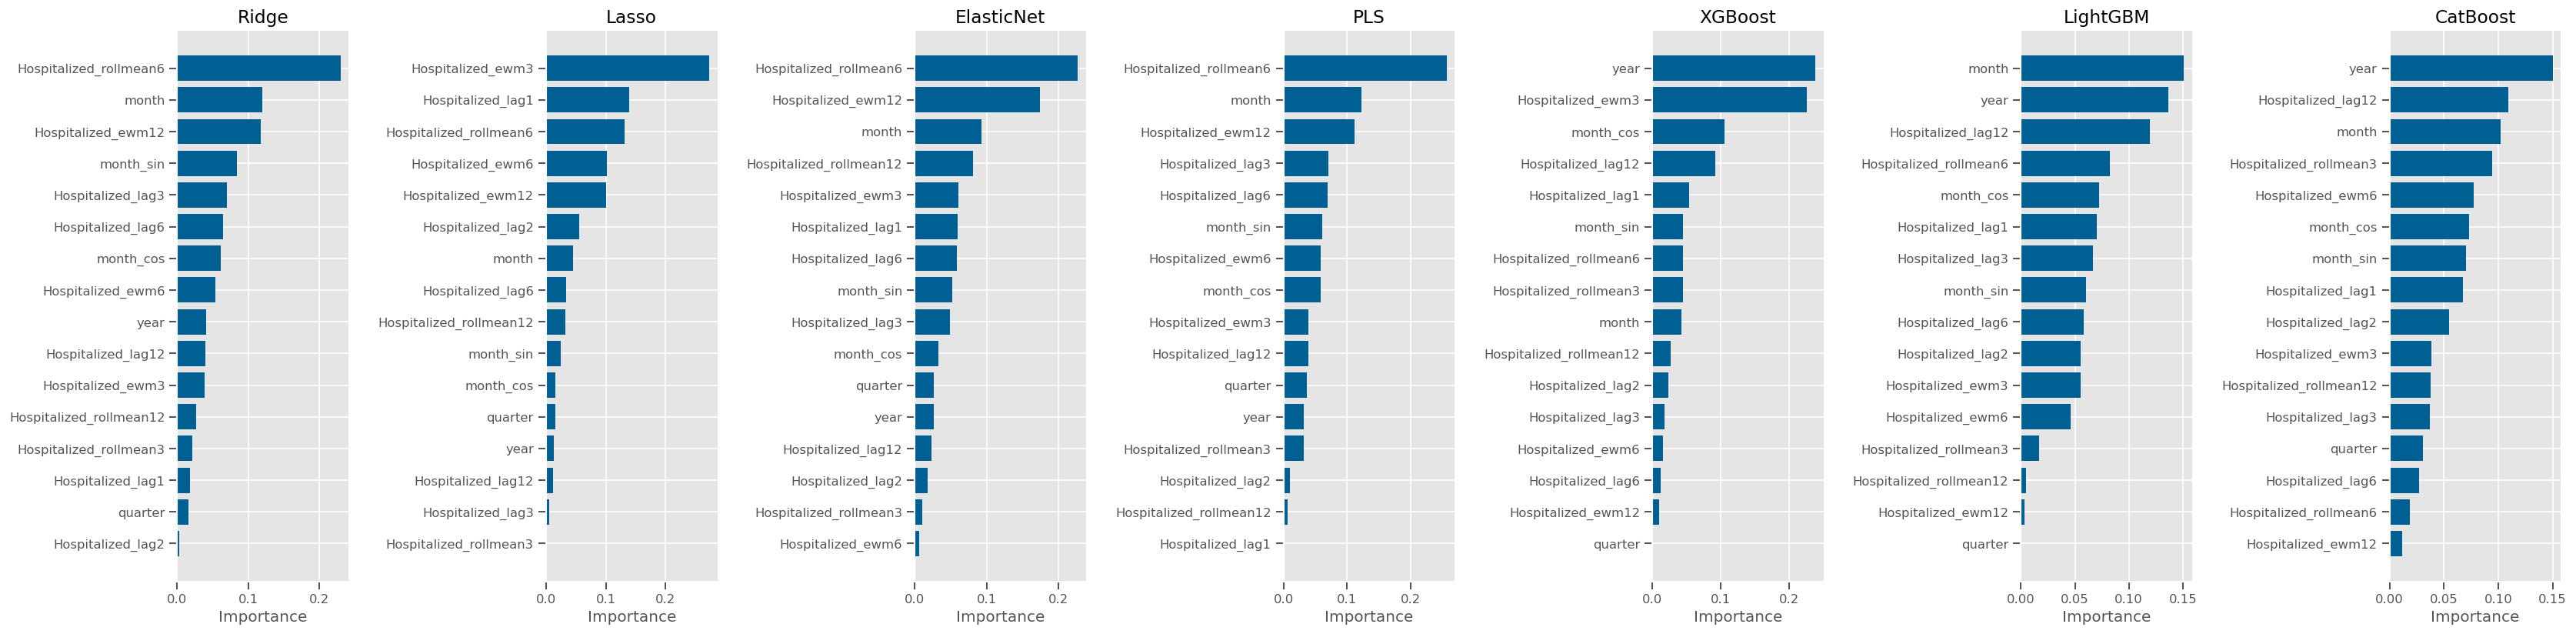

In [43]:
from src.plotting import plot_top_k_feature_importances

fig, axes = plot_top_k_feature_importances(
    feature_importances_national_m,
    k = 20,
)

plt.show()